# Getting features from NYC PLUTO

In this notebook, we will get and clean the NYC PLUTO Data. First, we extract relevant features from the NYC Pluto datasets. Specific features to be extracted include:
- Residential Units (sum of residential units in all buildings on the tax lot)
- Assessed Total Value (actual assessed total value for FY2015)
- Year Built (year construction of the building was completed)
- Year Altered 1 (if only one alteration then the year of the most recent alteration; otherwise the year of the second most recent alteration)
- Year Altered 2 (if more than one alteration then the year of the most recent alteration otherwise blank).
- BBL
- Census Tract (CT2010)

In [20]:
import pandas as pd
import re

### Read data in from downloaded csv file

def read_in_pluto_data():
    boroughs = {'bronx':'BX.csv', 'brooklyn':'BK.csv', 'Manhattan':'Mn.csv', 'Queens':'QN.csv', "Staten_island":'SI.csv'}
    frames = []
    for borough in boroughs.keys():
        df_name = borough + '_pluto'
        file_path = '../../data/nyc_pluto_15v1/' + boroughs[borough]
        df_name = pd.read_csv(file_path)
        df_name = df_name[['UnitsRes','AssessTot','YearBuilt','YearAlter1','YearAlter2','BBL', 'CT2010']]
        df_name = df_name[(df_name['UnitsRes'] != 0)]
        frames.append(df_name)
    result = pd.concat(frames, ignore_index=True)
    return result

pluto_dat = read_in_pluto_data()

In [21]:
pluto_dat.head(6)

,UnitsRes,AssessTot,YearBuilt,YearAlter1,YearAlter2,BBL,CT2010
0,8,104219,1920,2009,0,2022600018,19
1,8,25876,1920,0,0,2022610037,19
2,12,347400,1925,0,0,2022610045,19
3,1255,23375700,1956,0,0,2022630019,25
4,2,26820,2000,0,0,2022630065,25
5,2,26820,2000,0,0,2022630066,25


In processing the data, our goals it to:
- Pad the Ct2010 so it's in the format $d_1d_2d_3d_4d_5d_6$, where $d_5$ and $d_6$ are the decimal portion of the census tract number.
- Construct two new features:
  - Year of last alteration, defined as $\max\{YearAlter1, YearAlter2\}$.
  - Avg_value_per_res_unit, defined as total assessed value per residential unit (constructed as $AssessTot/UnitRes$)
- Drop YearAlter1 and YearAlter2.
- Drop any rows with missing values

In [22]:
def proc_tract(val):
    val = str(val)
    split_val = re.split('\.',val)
    if len(split_val) == 1:
        integer = split_val[0].zfill(4)
        decimal = '00'
    elif len(split_val) == 2:
        integer = split_val[0].zfill(4)
        decimal = split_val[1].ljust(2, '0')
    new_code = integer + decimal
    return new_code

In [23]:
pluto_dat['CT2010'] = pluto_dat['CT2010'].map(proc_tract)
pluto_dat['YearLastAlter'] = pluto_dat[['YearAlter1','YearAlter2']].max(axis=1)
pluto_dat = pluto_dat.drop(['YearAlter1','YearAlter2'],axis=1)
pluto_dat['Avg_value_per_res_unit'] = pluto_dat['AssessTot']/pluto_dat['UnitsRes']
pluto_dat.shape

(760834, 7)

In [24]:
pluto_dat = pluto_dat[~(pluto_dat.isnull().any(axis=1))]
pluto_dat.shape

(760833, 7)

In [25]:
pluto_dat.head(6)

,UnitsRes,AssessTot,YearBuilt,BBL,CT2010,YearLastAlter,Avg_value_per_res_unit
0,8,104219,1920,2022600018,001900,2009,13027.375000
1,8,25876,1920,2022610037,001900,0,3234.500000
2,12,347400,1925,2022610045,001900,0,28950.000000
3,1255,23375700,1956,2022630019,002500,0,18626.055777
4,2,26820,2000,2022630065,002500,0,13410.000000
5,2,26820,2000,2022630066,002500,0,13410.000000


To continue cleaning our data, we next look at the summary statistics for each feature to ensure there are no obviously incorrect values.

In [26]:
pluto_dat.describe()

,UnitsRes,AssessTot,YearBuilt,BBL,YearLastAlter,Avg_value_per_res_unit
count,760833.000000,7.608330e+05,760833.000000,7.608330e+05,760833.000000,760833.000000
mean,4.606973,1.808652e+05,1936.691692,3.548022e+09,171.911084,25533.416697
std,41.255516,2.236508e+06,86.719223,1.002855e+09,560.442966,144060.821811
min,1.000000,0.000000e+00,0.000000,1.000070e+09,0.000000,0.000000
25%,1.000000,2.152400e+04,1920.000000,3.037590e+09,0.000000,12656.000000
50%,2.000000,2.751300e+04,1930.000000,4.012820e+09,0.000000,17865.000000
75%,2.000000,3.804400e+04,1955.000000,4.107100e+09,0.000000,25320.000000
max,13248.000000,6.936678e+08,2015.000000,5.080500e+09,2015.000000,51051150.000000


There are clearly misentered values for YearBuilt and YearLastAlter (since no buildings currently occupied in New York were built in the year 0). Thus, our final cleaning step is to:
- Convert YearBuilt and YearLastAlter to age features (i.e. number of years, not the actual calendar year)
- Drop records with YearBuilt = YearLastAlter = 0

In [27]:
pluto_dat['BuildingAge'] = 2015 - pluto_dat['YearBuilt']
pluto_dat['YearSinceLastAlter'] = 2015 - pluto_dat['YearLastAlter']
pluto_dat = pluto_dat.drop(['YearBuilt', 'YearLastAlter'],axis=1)
mask = (pluto_dat['YearSinceLastAlter'] == 2015)
pluto_dat.loc[mask,'YearSinceLastAlter'] = pluto_dat['BuildingAge']
pluto_dat.head(6)

,UnitsRes,AssessTot,BBL,CT2010,Avg_value_per_res_unit,BuildingAge,YearSinceLastAlter
0,8,104219,2022600018,001900,13027.375000,95,6
1,8,25876,2022610037,001900,3234.500000,95,95
2,12,347400,2022610045,001900,28950.000000,90,90
3,1255,23375700,2022630019,002500,18626.055777,59,59
4,2,26820,2022630065,002500,13410.000000,15,15
5,2,26820,2022630066,002500,13410.000000,15,15


In [36]:
pluto_dat[pluto_dat.BuildingAge > 500].shape

(1355, 7)

We drop these records with building ages outside the reasonable range.

In [38]:
pluto_dat = pluto_dat[pluto_dat.BuildingAge < 500]
pluto_dat.shape

(759478, 7)

Finally, to start getting a sense of the marginal feature distributions, here are some histograms.

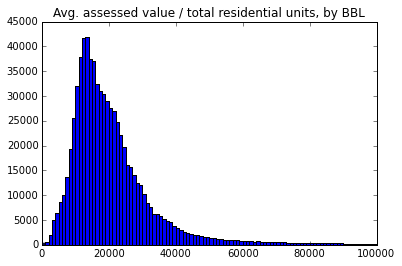

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

val_per_unit = plt.hist(pluto_dat['Avg_value_per_res_unit'], bins=100, range=(0,10**5))
plt.title('Avg. assessed value / total residential units, by BBL')
plt.show(val_per_unit)

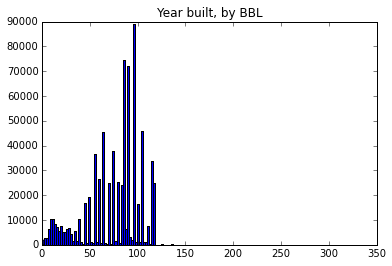

In [43]:
year_built = plt.hist(pluto_dat['BuildingAge'], bins=len(range(1850,2016)))
plt.title('Year built, by BBL')
plt.show(year_built)

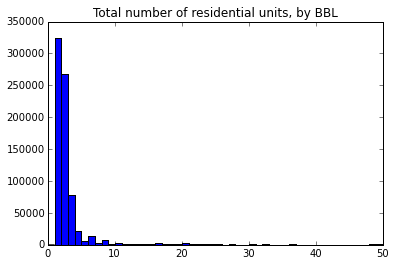

In [44]:
UnitsRes_hist = plt.hist(pluto_dat['UnitsRes'], bins=50, range=(0,50))
plt.title('Total number of residential units, by BBL')
plt.show(UnitsRes_hist)

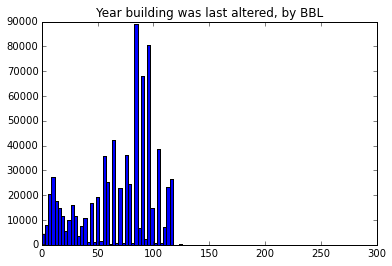

Number of buildings with no alterations reported =  695014


In [50]:
Year_mod = plt.hist(pluto_dat['YearSinceLastAlter'], bins=100)
plt.title('Year building was last altered, by BBL',)
plt.show(UnitsRes_hist)
print 'Number of buildings with no alterations reported = ', (pluto_dat['YearSinceLastAlter'] == pluto_dat['BuildingAge']).sum()

Notice the vast majority, $\frac{695014}{759478} \approx 91.5\%$, of buildings have no reported alterations.

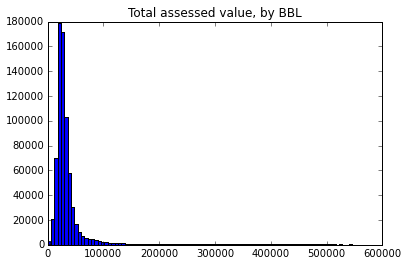

In [51]:
Tot_val = plt.hist(pluto_dat['AssessTot'], bins=100, range=(0,600000))
plt.title('Total assessed value, by BBL',)
plt.show(Tot_val)